In [1]:
#Блок 0: ввод параметров расчета: Откуда загружаем данные...

In [2]:
#Блок 1 с некоторыми вспомогательными элементами
#--------------------------------------------------------------------------------
#Импорт системных библиотек
import warnings
warnings.simplefilter("ignore")
#Импорт базовых библиотек анализа данных 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Функция для выдачи всех метрик
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, explained_variance_score
def regress_score(y_true, y_pred, Print = 'Yes'):
    # Calculate regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    mdape = np.median((np.abs(np.subtract(y_true, y_pred)/ y_true))) * 100
    if Print == 'Yes':
        print('MDAPE: ', mdape)
        print('Mean Absolute Error (MAE):', mae)
        print('Mean Squared Error (MSE):', mse)
        print('Median_absolute_error: ', medae)
        print('R2: ', r2)
        print('Explained_variance_score: ', evs)
    
    return [r2, mdape]


#Функция расчета расстояния между координатами
import math
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance in meters between two points given their latitude and longitude coordinates.
    """
    # Radius of the Earth in meters
    earth_radius = 6371000
    # Convert degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    # Calculate the differences between the latitudes and longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    # Haversine formula
    a = math.sin(delta_lat/2) * math.sin(delta_lat/2) + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon/2) * math.sin(delta_lon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    # Calculate the distance
    distance = earth_radius * c

    return distance

In [5]:
#Блок 2: Загрузка файла Excel, отсев продажи бизнеса, вычисление стоимости за м2
#--------------------------------------------------------------------------------
PATH = #адрес файла Excel
df_file_name = PATH + 'Df2023_07_05_09_48_30.xlsx'

#Убираем объявления с продажей бизнеса
from sklearn.preprocessing import OneHotEncoder 
data = pd.read_excel(df_file_name) 
print('Кол-во наблюдений в исходном датасете '+str(len(data)))
data = data[data['Ready Business?']!='"rentalBusiness"']
data = data[data['Ready Business?']!='"readyBusiness"']
data = data[(data['Full Price']<0)|(data['Full Price']>0)]
data['Price Per Square Meter'] = data['Full Price']/data['Total Area']

print('Кол-во наблюдений после фильтрации бизнеса по факторам ЦИАН '+str(len(data)))

Кол-во наблюдений в исходном датасете 1509
Кол-во наблюдений после фильтрации бизнеса по факторам ЦИАН 1157


In [7]:
#Поправка наблюдений, в которых цена за квадратный метр попала в общую стоимость
X = 1000000

# Сохраняем значения df['Price Per Square Meter'] и df['Full Price'] в отдельные переменные
price_per_square_meter_values = data.loc[data['Full Price'] < X, 'Price Per Square Meter'].copy()
full_price_values = data.loc[data['Full Price'] < X, 'Full Price'].copy()

# Заменяем значения в колонке 'Price Per Square Meter'
data.loc[data['Full Price'] < X, 'Price Per Square Meter'] = full_price_values

# Заменяем значения в колонке 'Full Price'
data.loc[data['Full Price'] < X, 'Full Price'] = price_per_square_meter_values

# Выводим измененный датафрейм
#display(data[data['Full Price'] < 1000000])

Кол-во наблюдений после фильтрации зданий до 1950 года (у которых заполнено) 1026


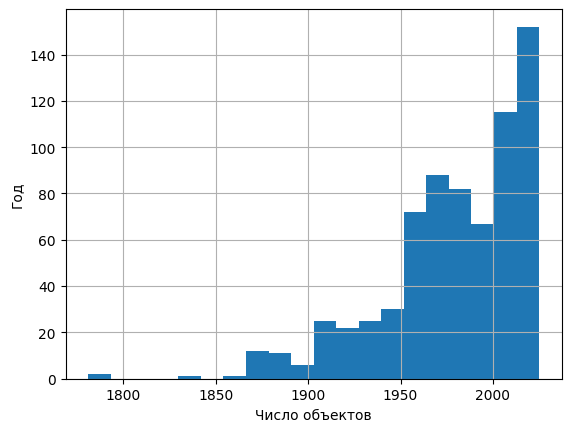

In [8]:
data['Build Year'].value_counts()
data['Build Year'].hist(bins=20)
plt.xlabel('Число объектов')
plt.ylabel('Год')

#Очистка по дате
data = data[(data['Build Year'] > 1950) | data['Build Year'].isnull()]
print('Кол-во наблюдений после фильтрации зданий до 1950 года (у которых заполнено) '+str(len(data)))

In [9]:
#Блок 2.1 поправкa данных  
#--------------------------------------------------------------------------------

#Обмен местами значений столбцов, если общая стоимость меньше 1млн 
#mask = data['Full Price'] < 1000000
#data.loc[mask, ['Price Per Square Meter', 'Full Price']] = data.loc[mask, ['Full Price', 'Price Per Square Meter']].values
#data[['Id Promotion', 'Price Per Square Meter', 'Full Price']].sort_values('Price Per Square Meter').head(20)

#Детекция цоколя
data['Tcokol'] = data['Description'].str.contains('цок', case=False, na=False).astype(int)
data = data[data['Tcokol']==0]
data = data.drop('Tcokol', axis=1)
print('Кол-во наблюдений после фильтрации цоколя '+str(len(data)))

#Доп детекция бизнеса
data['Buis'] = data['Description'].str.contains('вый бизнес', case=False, na=False).astype(int)
data = data[data['Buis']==0]
print('Кол-во наблюдений после доп фильтрации бизнеса '+str(len(data)))

#Детекция склада
data['Sklad'] = data['Description'].str.contains('клад', case=False, na=False).astype(int)
data = data[data['Sklad']==0]
data = data.drop('Sklad', axis=1)
print('Кол-во наблюдений после фильтрации склада '+str(len(data)))

#Детекция автомоек
data['CarWasher'] = data['Description'].str.contains('втомойка', case=False, na=False).astype(int)
data = data[data['CarWasher']==0]
data = data.drop('CarWasher', axis=1)
print('Кол-во наблюдений после фильтрации автомоек '+str(len(data)))


Кол-во наблюдений после фильтрации цоколя 982
Кол-во наблюдений после доп фильтрации бизнеса 972
Кол-во наблюдений после фильтрации склада 935
Кол-во наблюдений после фильтрации автомоек 925


In [ ]:
#Детекция дублей
from difflib import SequenceMatcher
# Функция для вычисления сходства текста в процентах
def text_similarity(text1, text2):
    return SequenceMatcher(None, text1, text2).ratio() * 100

# Поиск наблюдений с совпадающим текстом на 90% и длиной текста > 100 символов
similar_observations = []
for idx1, desc1 in data[['Id Promotion', 'Description']].iterrows():
    for idx2, desc2 in data[['Id Promotion', 'Description']].iterrows():
        if idx1 != idx2:
            if len(desc1['Description']) > 100 and len(desc2['Description']) > 100:
                similarity = text_similarity(desc1['Description'], desc2['Description'])
                if similarity >= 99:
                    similar_observations.append((desc1['Id Promotion'], desc2['Id Promotion'], similarity))

# Вывод найденных совпадений
listDubl = []
for obs in similar_observations:
    id1, id2, similarity = obs
    listDubl.append(id2)

data = data[~data['Id Promotion'].isin(listDubl)]
print('Кол-во наблюдений после фильтрации дублей '+str(len(data)))

## Конец фильтрации данных

## Начало фичаинжиниринга

In [10]:
data_feature_engine = data.copy()

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

silhouette = 0
for N_CLUSTERS in range(5, 13):


    # Преобразование координат в отклонение от центра Красной площади в метрах
    red_square_lat = 55.7538337
    red_square_lng = 37.6211812

    data_feature_engine['X'] = (data_feature_engine['Lat'] - red_square_lat) * 111000  # Приблизительное значение 1 градуса широты в метрах
    data_feature_engine['Y'] = (data_feature_engine['Lng'] - red_square_lng) * 111000 * np.cos(np.deg2rad(red_square_lat))  # Приблизительное значение 1 градуса долготы в метрах

    # Кластеризация методом иерархической кластеризации
    clustering = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit(data_feature_engine[['X', 'Y']])

    # Добавление меток кластеров в DataFrame
    data_feature_engine['Cluster'] = clustering.labels_

    # Отображение топ кластеров по объему наблюдений и среднему значению 'Price Per Square Meter'
    top_clusters = data_feature_engine['Cluster'].value_counts().nlargest(N_CLUSTERS).index
    for cluster in top_clusters:
        cluster_data = data_feature_engine[data_feature_engine['Cluster'] == cluster]
        cluster_mean_price = cluster_data['Price Per Square Meter'].mean()
        #print("Cluster:", cluster)
        #print("Observations:", len(cluster_data))
        #print("Average Price Per Square Meter:", cluster_mean_price)
        #print("-------")

    old_silhouette = silhouette
    # Вычисление метрики силуэтта
    silhouette = silhouette_score(data_feature_engine[['X', 'Y']], clustering.labels_)

    # Вывод метрики силуэтта
    print("Число кластеров "+str(N_CLUSTERS))
    print("Silhouette Score:", silhouette)
    print("Diff Silhouette Score:", silhouette-old_silhouette)
    print("-------")

from matplotlib.colors import ListedColormap
# Отображение данных
#colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'magenta']
#plt.scatter(data_feature_engine['X'], data_feature_engine['Y'], c=data_feature_engine['Cluster'], cmap=ListedColormap(colors))
#plt.xlabel('X (meters)')
#plt.ylabel('Y (meters)')
#plt.title('Data Visualization')
#plt.show()

Число кластеров 5
Silhouette Score: 0.3733661422633166
Diff Silhouette Score: 0.3733661422633166
-------
Число кластеров 6
Silhouette Score: 0.3643237140278026
Diff Silhouette Score: -0.009042428235513988
-------
Число кластеров 7
Silhouette Score: 0.35850286493613037
Diff Silhouette Score: -0.005820849091672242
-------
Число кластеров 8
Silhouette Score: 0.370687847768
Diff Silhouette Score: 0.01218498283186964
-------
Число кластеров 9
Silhouette Score: 0.39651277261622997
Diff Silhouette Score: 0.025824924848229958
-------
Число кластеров 10
Silhouette Score: 0.4015244838768833
Diff Silhouette Score: 0.0050117112606533065
-------
Число кластеров 11
Silhouette Score: 0.4175323940270732
Diff Silhouette Score: 0.01600791015018993
-------
Число кластеров 12
Silhouette Score: 0.4302689466471054
Diff Silhouette Score: 0.012736552620032204
-------


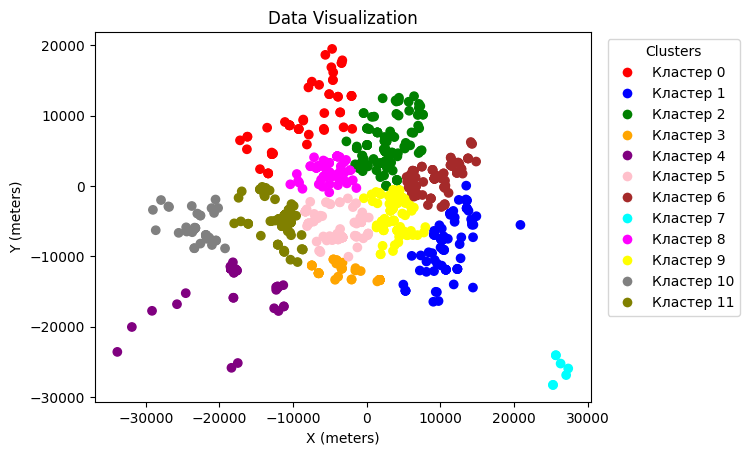

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'cyan', 'magenta', 'yellow', 'gray', 'olive']

# Создание colormap с использованием списка цветов
cmap = ListedColormap(colors)

# График рассеяния с использованием цветов кластеров
plt.scatter(data_feature_engine['X'], data_feature_engine['Y'], c=data_feature_engine['Cluster'], cmap=cmap)


# Создание легенды
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label='Кластер '+str(i)) for i, color in enumerate(colors)]
plt.legend(handles=legend_elements, title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left')


plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('Data Visualization')
plt.show()


In [ ]:
#Перкодируем категориальную переменную кластера Вариант 1: ванхотэнкодинг
ohe = OneHotEncoder(sparse=False) 
new_ohe_features = ohe.fit_transform(data_feature_engine['Cluster'].values.reshape(-1, 1))
tmp = pd.DataFrame(new_ohe_features, columns=['Кластер ' + str(cluster) + '?' for cluster in data_feature_engine['Cluster'].value_counts().index])
#Добавим новые переменные
data_feature_engine = pd.concat([data_feature_engine, tmp], axis=1)
data_feature_engine = data_feature_engine[(data_feature_engine['Full Price']<0)|(data_feature_engine['Full Price']>0)]

display(data_feature_engine.columns.tolist())

In [ ]:
#Блок 5: фичаинжиниринга РАЙОНА
#Запускать ровно 1 раз (иначе просто начать заново)
#--------------------------------------------------------------------------------
#Перкодируем категориальную переменную района Вариант 1: ванхотэнкодинг
ohe = OneHotEncoder(sparse=False) 
new_ohe_features = ohe.fit_transform(data_feature_engine['District'].values.reshape(-1, 1))
tmp = pd.DataFrame(new_ohe_features, columns=list(data_feature_engine['District'].value_counts().index))
#Добавим новые переменные
#data_feature_engine = pd.concat([data, tmp], axis=1)
#После перекодировки в датасете появляется очень много NaN
data_feature_engine = data_feature_engine[(data_feature_engine['Full Price']<0)|(data_feature_engine['Full Price']>0)]

#Перкодируем геолокацию в расстояние до основных коммерческих райнов Москвы
Tverskoy_District = [55.7642, 37.6052]
Arbat_District = [55.7492, 37.5886]
Presnensky_District = [55.7525, 37.5394]
Khamovniki_District = [55.7339, 37.5631]
Basmanny_District = [55.7656, 37.6634]
Zamoskvorechye_District = [55.7263, 37.6432]
Yakimanka_District = [55.7355, 37.6269]
Meshchansky_District = [55.7733, 37.6331]
red_square = [55.7538337, 37.6211812]
nizhegorodsky_district = [55.7383, 37.7228]
yuzhnoportovy_district = [55.7333, 37.6672]

tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Tverskoy_District[0], Tverskoy_District[1]), axis=1)
#data_feature_engine['Distance Tverskoy District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Arbat_District[0], Arbat_District[1]), axis=1)
#data_feature_engine['Distance Arbat District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Presnensky_District[0], Presnensky_District[1]), axis=1)
#data_feature_engine['Distance Presnensky District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Khamovniki_District[0], Khamovniki_District[1]), axis=1)
#data_feature_engine['Distance Khamovniki District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Basmanny_District[0], Basmanny_District[1]), axis=1)
#data_feature_engine['Distance Basmanny District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Zamoskvorechye_District[0], Zamoskvorechye_District[1]), axis=1)
#data_feature_engine['Distance Zamoskvorechye District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Yakimanka_District[0], Yakimanka_District[1]), axis=1)
#data['Distance Yakimanka District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], Meshchansky_District[0], Meshchansky_District[1]), axis=1)
#data_feature_engine['Distance Meshchansky District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], red_square[0], red_square[1]), axis=1)
data_feature_engine['Distance Red Square'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], nizhegorodsky_district[0], nizhegorodsky_district[1]), axis=1)
#data_feature_engine['Distance Nizhegorodsky District'] = tmp 
tmp = data.apply(lambda row: calculate_distance(row['Lat'], row['Lng'], yuzhnoportovy_district[0], yuzhnoportovy_district[1]), axis=1)
#data_feature_engine['Distance Yuzhnoportovy District'] = tmp 



display(data_feature_engine.columns.tolist())

## Конец фичаинжиниринга

In [14]:
data_feature_engine['Srochn'] = data_feature_engine['Description'].str.contains('рочн', case=False, na=False).astype(int)
data_feature_engine['Exclusive'] = data_feature_engine['Description'].str.contains('ксклюзи', case=False, na=False).astype(int)
data_feature_engine['Security'] = data_feature_engine['Description'].str.contains('охран', case=False, na=False).astype(int)


display(data_feature_engine['Srochn'].value_counts())
display(data_feature_engine['Exclusive'].value_counts())
display(data_feature_engine['Security'].value_counts())

0    883
1     42
Name: Srochn, dtype: int64

0    917
1      8
Name: Exclusive, dtype: int64

0    794
1    131
Name: Security, dtype: int64

In [15]:
#Блок 4: выделения "среднего" сегмента
#--------------------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder 
print('Кол-во наблюдений в общем датасете: '+str(len(data_feature_engine)))
data1 = data_feature_engine

data_train = data_feature_engine.groupby('Cluster').apply(lambda x: x[x['Price Per Square Meter'] > 0.7 * x['Price Per Square Meter'].median()])

data_train = data_train[data_train['Srochn']==0]
data_train = data_train[data_train['Exclusive']==0]
#data_train = data_train[data_train['Security']==0]

#data_train = data_feature_engine[data_feature_engine['Price Per Square Meter']>0.8*data_feature_engine['Price Per Square Meter'].median()]


RowsToDrop = ['Ready Business?', 
              'Material Type', 
              'Description', 
              'Id Promotion', 
              'Id User', 
              'Creation Date', 
              'Unnamed: 0', 
              'District', 
              'Full Price',
             'Lat', 'Lng', 'Buis', 'Cluster', 'Srochn', 'Exclusive']

data_train = data_train.drop(RowsToDrop, axis=1, inplace=False)


print('Кол-во наблюдений в датасете "среднего" сегмента: '+str(len(data_train)))

Кол-во наблюдений в общем датасете: 925
Кол-во наблюдений в датасете "среднего" сегмента: 694


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

r2test = 0
r2train = 1

while r2train-r2test>0.1 or r2train<0.5:
    PredictVariable = 'Price Per Square Meter'
    y = data_train[PredictVariable]
    X = data_train.drop([PredictVariable], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    base_model = DecisionTreeRegressor(max_depth=4)
    
    pipeline = Pipeline(
        steps=[
            ('imputer', SimpleImputer()),  # Заполнение пропущенных значений
            ('adaboost', AdaBoostRegressor(base_model, n_estimators=200, learning_rate=0.1, random_state=42))
        ]
    )
    
    
    pipeline.fit(X_train, y_train)
    y_pred_ADA = pipeline.predict(X_test)
    y_train_pred_ADA = pipeline.predict(X_train)
    
    r2train = regress_score(y_train, y_train_pred_ADA, 'No')[0]   
    r2test = regress_score(y_test, y_pred_ADA, 'No')[0]

print('Тренировочная выборка:')    
regress_score(y_train, y_train_pred_ADA, 'Yes')
print('\nТестовая выборка:')
regress_score(y_test, y_pred_ADA, 'Yes')




Тренировочная выборка:
MDAPE:  20.168151236183903
Mean Absolute Error (MAE): 47714.665596197985
Mean Squared Error (MSE): 3175727114.2405877
Median_absolute_error:  45288.91199083936
R2:  0.6180902634929444
Explained_variance_score:  0.623924874878313

Тестовая выборка:
MDAPE:  20.65244510783008
Mean Absolute Error (MAE): 50008.02198120776
Mean Squared Error (MSE): 3819560923.0852556
Median_absolute_error:  44870.19049285515
R2:  0.546279012203285
Explained_variance_score:  0.5681869528439334


[0.546279012203285, 20.65244510783008]

In [ ]:
data1_droped = data1.drop(RowsToDrop, axis=1, inplace=False)
ydata1_test = data1_droped[PredictVariable]
Xdata1 = data1_droped.drop([PredictVariable], axis=1, inplace=False)
Xdata1 = scaler.transform(Xdata1)
y_data1_ADA = pipeline.predict(Xdata1)

data11=data1.copy()
data11['y_data1_ADA'] = y_data1_ADA
data11['Difference %'] = 100*(data11['y_data1_ADA']-data11['Price Per Square Meter'])/data11['Price Per Square Meter'] 

data11= data11[data11['Difference %']<30000]
data11.sort_values('Difference %')


with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(data11[['Id Promotion', 'Difference %', 'Price Per Square Meter','y_data1_ADA']].sort_values('Difference %', ascending=False))

In [26]:
#Блок 5: ручного прогона градиентного бустинга
#--------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from xgboost import plot_importance

r2test = 0
r2train = 1

while r2train-r2test>0.1:
    PredictVariable = 'Price Per Square Meter'
    y = data_train[PredictVariable]
    X = data_train.drop([PredictVariable], axis=1, inplace=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = XGBRegressor(n_estimators=70, max_depth=3, subsample=0.7, colsample_bytree=1,
                     reg_alpha=1, reg_lambda=1,
                     gamma=1, min_child_weight=6, learning_rate=0.1,
                     objective='reg:squarederror')
    model.fit(X_train, y_train)
    y_pred_XGB = model.predict(X_test)
    y_train_pred_XGB = model.predict(X_train)
    
    r2train = regress_score(y_train, y_train_pred_XGB, 'No')[0]   
    r2test = regress_score(y_test, y_pred_XGB, 'No')[0]

print('Тренировочная выборка:')    
regress_score(y_train, y_train_pred_XGB, 'Yes')
print('\nТестовая выборка:')
regress_score(y_test, y_pred_XGB, 'Yes')


#n_estimators от 50 до 150 - 80 learning_rate от 0.05 до 0.2 max_depth от 5 до 20

Тренировочная выборка:
MDAPE:  12.617847203424038
Mean Absolute Error (MAE): 35767.1200865355
Mean Squared Error (MSE): 2139469332.8209655
Median_absolute_error:  27571.81156015038
R2:  0.7422330623214759
Explained_variance_score:  0.7422346286417625

Тестовая выборка:
MDAPE:  13.355412654200194
Mean Absolute Error (MAE): 40456.48441639701
Mean Squared Error (MSE): 2775847369.254534
Median_absolute_error:  31118.202323717953
R2:  0.673598031461222
Explained_variance_score:  0.6737102989610202


[0.673598031461222, 13.355412654200194]

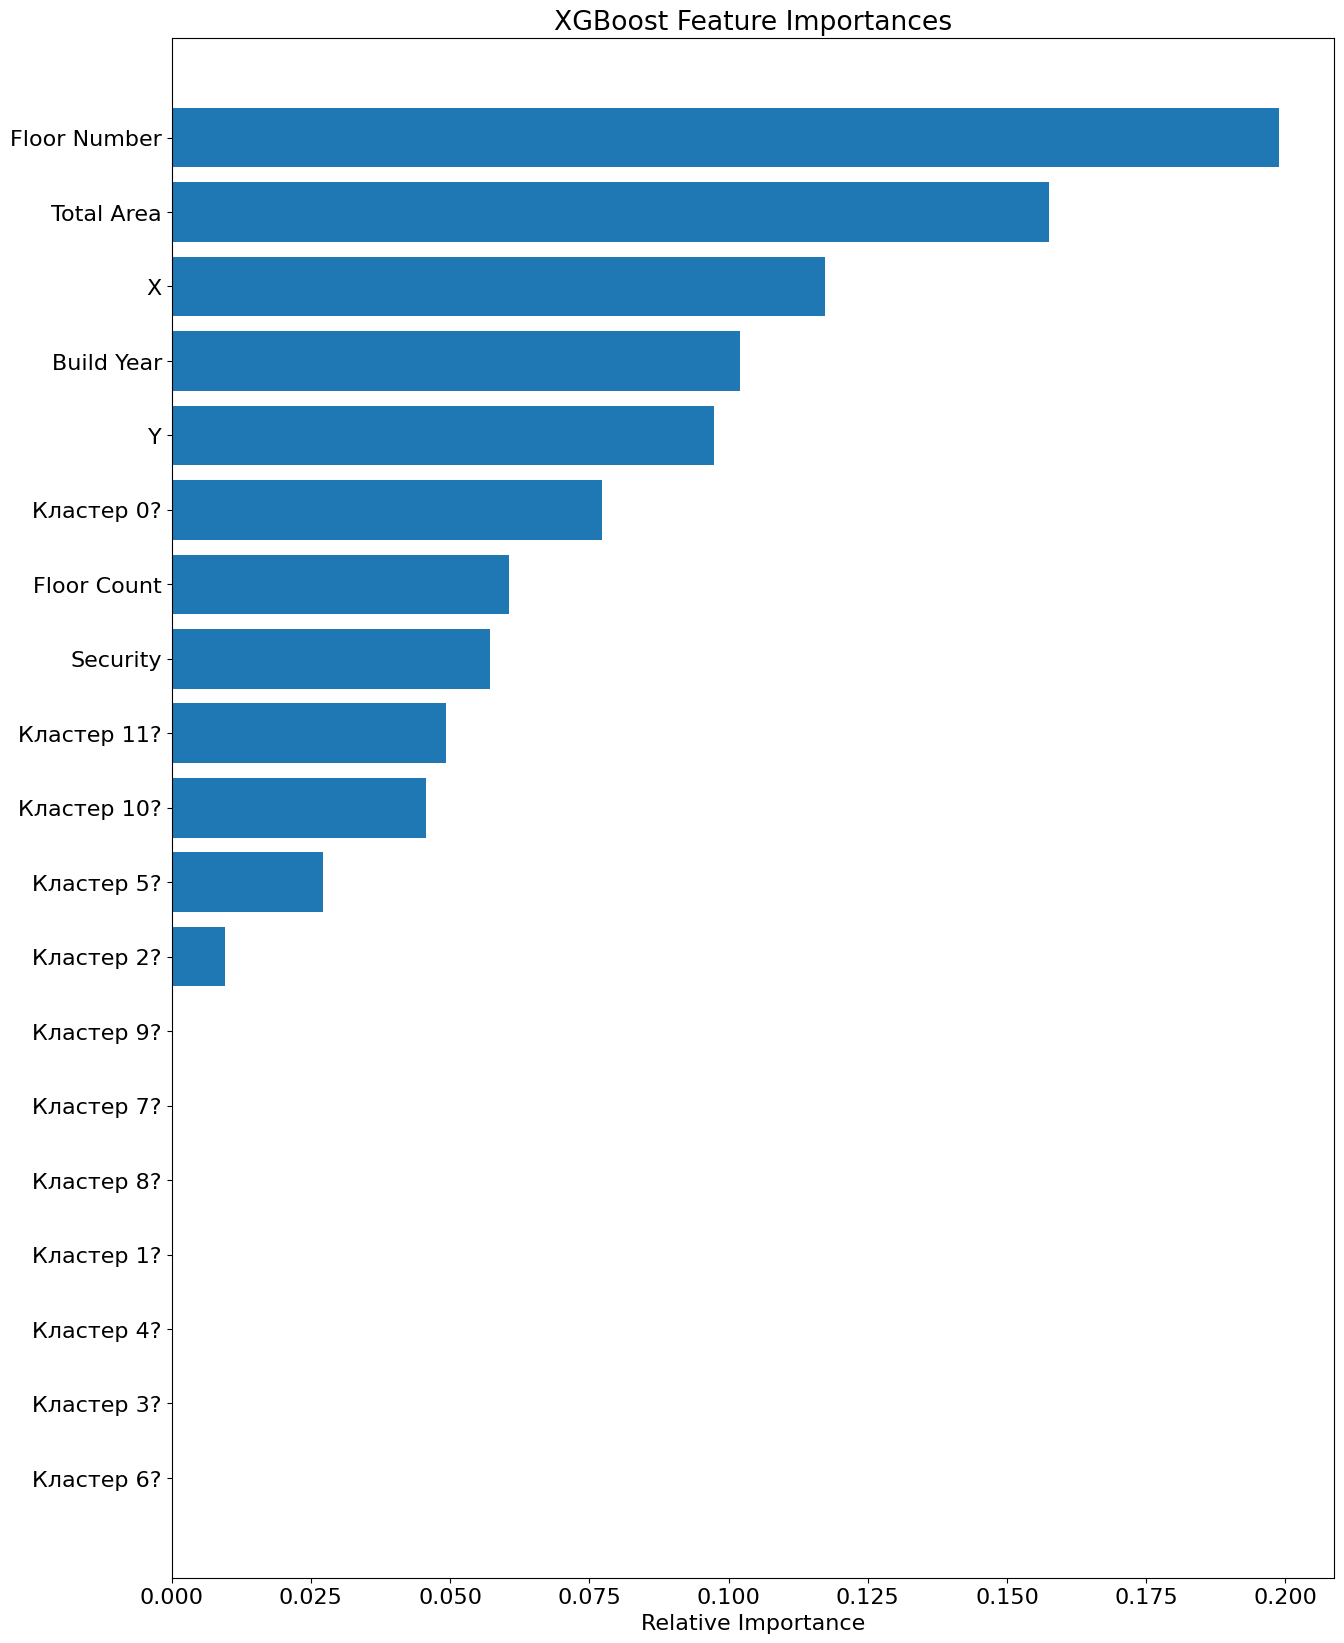

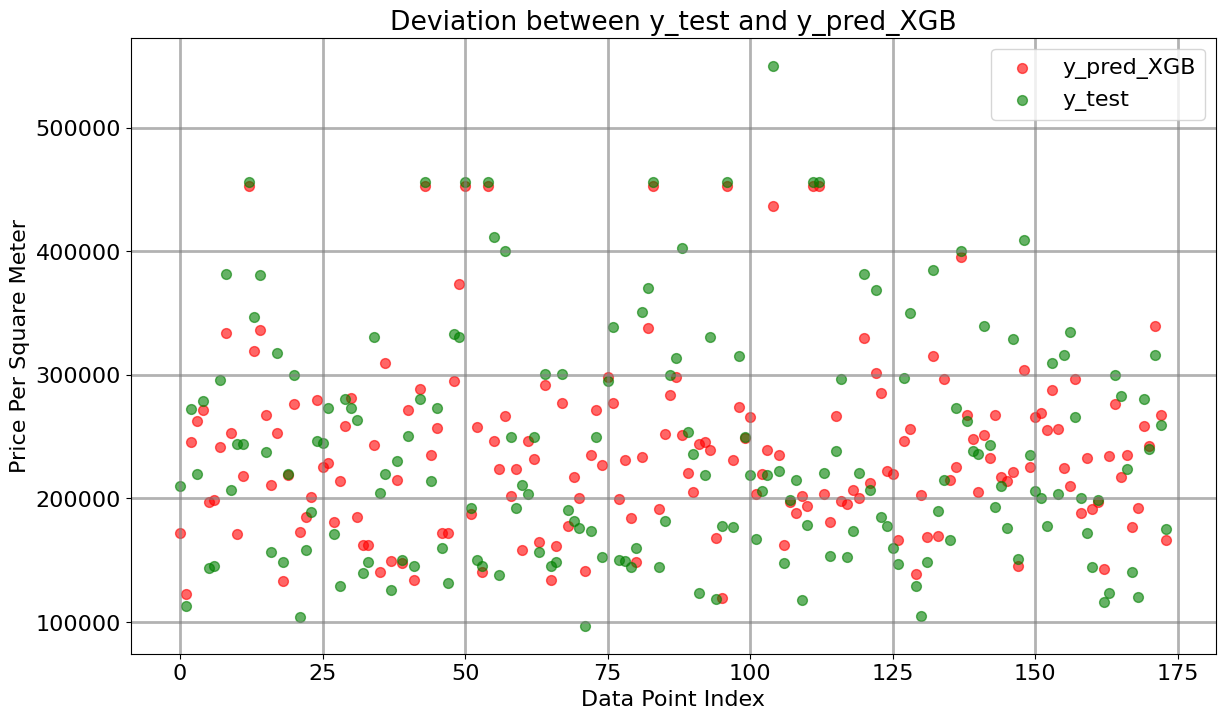

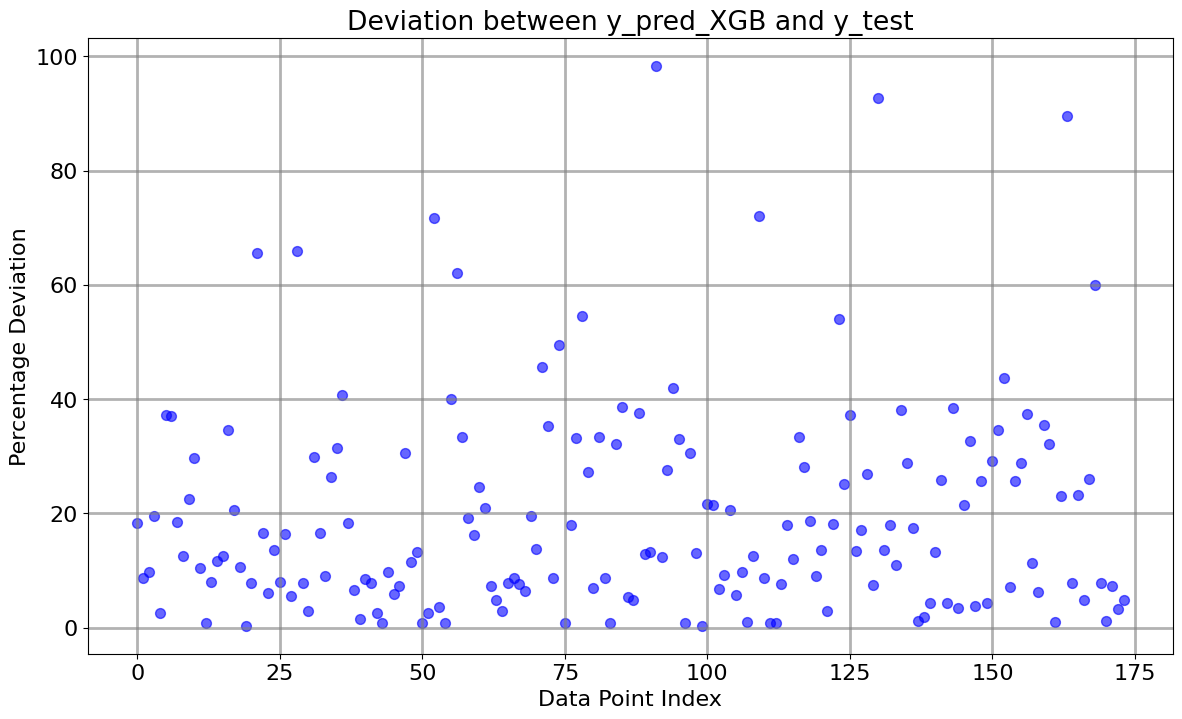

In [27]:
#Блок 6 визуализации: важность факторов, график с прогнозной стоимостью на тестовой выборке
#--------------------------------------------------------------------------------
#Анализ важности факторов
feature_names = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-100:]
fig, ax = plt.subplots(figsize=(15, 20))
plt.rcParams.update({'font.size': 16})
ax.barh(range(len(indices)), importances[indices], align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(feature_names[indices])
ax.set_xlabel('Relative Importance')
ax.set_title('XGBoost Feature Importances')
plt.show()

#Сравнение прогнозируемой стоимости
x = np.arange(0, len(y_pred_XGB))
fig, ax = plt.subplots(figsize=(14, 8))
# Scatter plots with adjusted marker size and transparency
ax.scatter(x, y_pred_XGB, color='red', label='y_pred_XGB', alpha=0.6, s=50)
ax.scatter(x, y_test, color='green', label='y_test', alpha=0.6, s=50)
# Calculate and plot the trend line
ax.set_xlabel('Data Point Index')
ax.set_ylabel('Price Per Square Meter')
ax.set_title('Deviation between y_test and y_pred_XGB')
ax.legend()
#Сетка
ax.grid(True, linewidth=2, which='both', linestyle='-', axis='both', color='gray',alpha=0.6) # Add gridlines
plt.show()

# Вычислите процент отклонения
deviation_percentage = np.abs((y_pred_XGB - y_test)/y_test )*100
# Создание графика
x = np.arange(0, len(y_pred_XGB))
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(x, deviation_percentage, color='blue', alpha=0.6, s=50)
ax.set_xlabel('Data Point Index')
ax.set_ylabel('Percentage Deviation')
ax.set_title('Deviation between y_pred_XGB and y_test')
ax.grid(True, linewidth=2, which='both', linestyle='-', color='gray', alpha=0.6)
plt.show()

In [ ]:
data1_droped = data1.drop(RowsToDrop, axis=1, inplace=False)
ydata1_test = data1_droped[PredictVariable]
Xdata1 = data1_droped.drop([PredictVariable], axis=1, inplace=False)
Xdata1 = scaler.transform(Xdata1)
y_data1_XGB = model.predict(Xdata1)

data11=data1.copy()
data11['y_data1_XGB'] = y_data1_XGB
data11['Difference %'] = 100*(data11['y_data1_XGB']-data11['Price Per Square Meter'])/data11['Price Per Square Meter'] 

data11= data11[data11['Difference %']<1500]
data11.sort_values('Difference %')


with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(data11[['Id Promotion', 'Difference %', 'Price Per Square Meter','y_data1_XGB']].sort_values('Difference %', ascending=False))

In [31]:
data1_droped = data1.drop(RowsToDrop, axis=1, inplace=False)
ydata1_test = data1_droped[PredictVariable]
Xdata1 = data1_droped.drop([PredictVariable], axis=1, inplace=False)
Xdata1 = scaler.transform(Xdata1)
y_data1_XGB = model.predict(Xdata1)

data11=data1.copy()
data11['y_data1_XGB'] = y_data1_XGB
data11['Difference %'] = (data11['y_data1_XGB']-data11['Price Per Square Meter'])/data11['Price Per Square Meter'] 
data11['Difference %'] = data11['Difference %'].multiply(100)
data11.sort_values('Difference %')
data11['Predicted'] = data11['y_data1_XGB']
data11['Fact'] = data11['Price Per Square Meter']
#data11 = data11[data11['Difference %']<2100]


In [ ]:



tmp_data = data11[['Id Promotion', 'Difference %', 'Predicted', 'Fact', 'Total Area', 'Floor Number', 'Floor Count', 'Material Type', 'Build Year', 'Description']].sort_values('Difference %', ascending=False)

tmp_data = data11[['Id Promotion', 'Difference %', 'Predicted', 'Fact', 'Total Area', 'Floor Number', 'Floor Count', 'Material Type', 'Build Year', 'Description']].sort_values('Difference %', ascending=False)
tmp_data = tmp_data[tmp_data['Build Year']<2023]
tmp_data = tmp_data[tmp_data['Build Year']>2000]


print('Кол-во наблюдений до фильтрации аренды '+str(len(tmp_data)))
#Детекция автомоек
tmp_data['Arend'] = tmp_data['Description'].str.contains('аренд', case=False, na=False).astype(int)
tmp_data = tmp_data[tmp_data['Arend']==0]
tmp_data = tmp_data.drop('Arend', axis=1)
print('Кол-во наблюдений после фильтрации аренды '+str(len(tmp_data)))

tmp_data['Torg'] = tmp_data['Description'].str.contains('овое помещ', case=False, na=False).astype(int)
tmp_data = tmp_data[tmp_data['Torg']==0]
tmp_data = tmp_data.drop('Torg', axis=1)
print('Кол-во наблюдений после фильтрации торговых помещений '+str(len(tmp_data)))




##tmp_data['Appart'] = tmp_data['Description'].str.contains('сити', case=False, na=False).astype(int)
#tmp_data = tmp_data[tmp_data['Appart']>0]
#tmp_data = tmp_data.drop('Appart', axis=1)

#tmp_data = tmp_data[tmp_data['Difference %']>50]
#print('Кол-во наблюдений после фильтрации разности '+str(len(tmp_data)))

tmp_data = tmp_data.reset_index()
tmp_data.index = np.arange(1,len(tmp_data)+1)
tmp_data.rename(columns = {'Id Promotion':'Ссылка'}, inplace = True)
tmp_data.rename(columns = {'Fact':'Цена'}, inplace = True)
tmp_data.rename(columns = {'Total Area':'Площадь'}, inplace = True)
tmp_data.rename(columns = {'Floor Number':'Номер этажа'}, inplace = True)
tmp_data.rename(columns = {'Material Type':'Материал стен'}, inplace = True)
tmp_data.rename(columns = {'Floor Count':'Этажность'}, inplace = True)
tmp_data.rename(columns = {'Build Year':'Год постройки'}, inplace = True)


with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(tmp_data[['Цена', 'Площадь', 'Год постройки', 'Номер этажа', 'Этажность', 'Ссылка']])

In [ ]:
#import time 
#current_time_str = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime(time.time()))
#data11[['Id Promotion', 'District', 'Difference %', 'Predicted', 'Fact', 'Total Area', 'Floor Number', 'Floor Count', 'Material Type', 'Build Year']].sort_values('Difference %', ascending=False).to_excel(PATH+"TOPFULL_28_06"+current_time_str+".xlsx")

In [ ]:
dataoutput = data11[['Id Promotion', 'District', 'Difference %', 'Fact', 'Total Area', 'Floor Number', 'Floor Count', 'Material Type', 'Build Year']].sort_values('Difference %', ascending=False).head(30)
dataoutput = dataoutput.drop('Difference %', axis=1)
dataoutput = dataoutput.drop('District', axis=1)

dataoutput = dataoutput.rename(columns={'Id Promotion': 'Ссылка', 'Fact': 'Стоимость за кв.м. ', 'Total Area': 'Площадь', 'Floor Number': 'Номер этажа', 'Floor Count': 'Этажность', 'Material Type': 'Материал стен', 'Build Year': 'Год постройки'})
    
k = 0    
for index, row in dataoutput.iterrows():
    k = k +1
    print('Топ '+str(k))
    print(row)
    print('-------')


In [ ]:
condition = data11['Id Promotion'] == 'www.cian.ru/sale/commercial/288944087'
observation = data11[condition]
factors = observation.iloc[0].to_dict()

for factor, value in factors.items():
    print(f"{factor}: {value}")

    
description = observation.iloc[0]['Description']
print(description)

In [ ]:
data11[['Id Promotion', 'District', 'Difference %', 'Predicted', 'Fact', 'Total Area', 'Floor Number', 'Floor Count', 'Material Type', 'Build Year']].sort_values('Difference %', ascending=False).head(30).to_excel("TOPDf1506"+".xlsx")

In [ ]:
import time

current_time_str = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime(time.time()))
data11[['Id Promotion', 'District', 'Difference %', 'Predicted', 'Fact', 'Total Area', 'Floor Number', 'Floor Count', 'Material Type', 'Build Year']].sort_values('Difference %', ascending=False).head(30).to_excel(PATH+"TOP30Df"+current_time_str+".xlsx")

In [ ]:
#Сохраним модель
import pickle
import time 


PATH=#ваша папка


current_time_str = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime(time.time()))
with open(current_time_str+"_model.pkl", "wb") as f:
    pickle.dump(model, f)